# Policy Analysis

This notebook conducts the analysis of the policies that managers could chose to put in place to influence the performance of their sales force.

It begins by defining functions to run the model for a specific individual, given a specific policy, and another function to plot the results of the full population of individuals together.

It then defines a toy population that can be used to gain intuition for the impact of various policies, and evaluates a number of policy choices.

In [1]:
%pylab inline 
import pysd
import numpy as np
import multiprocessing
from functools import partial
import seaborn

Populating the interactive namespace from numpy and matplotlib


/Users/houghton/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
model = pysd.read_vensim('Three streamsc.mdl')

In [7]:
#simplifies one run of the model
def runner(case, params):
    """
    case: dict
        contains the parameters that are varied by the monte carlo simulation
    
    params: dict
        contains the model parameters that are set as the 'control'
    """
    model = pysd.load('Three streamsc.py')
    params.update(case)

    res = model.run(params,
                    return_columns=['still_employed', 'tier_1_sales',
                                    'tier_2_sales', 'tier_3_sales', 
                                    'tier_1_clients', 'tier_2_clients',
                                    'tier_3_clients'],
                    return_timestamps=[3, 36])
    
    month36_no_failout = res['still_employed'].loc[36] > 0
    month3_no_failout = res['still_employed'].loc[3] > 0
    
    month3_sales = (res['tier_1_sales'].loc[3]+
                    res['tier_2_sales'].loc[3]+
                    res['tier_3_sales'].loc[3])
            
    
    month36_clients = res['tier_1_clients'].loc[36] + res['tier_2_clients'].loc[36] + res['tier_3_clients'].loc[36]
    month36_orphans = 0 if month36_no_failout else month36_clients #note that to really capture orphans, we'd need to get the number of clients at the time when each agent fails...
    month36_tier3_clients = res['tier_3_clients'].loc[36]        
            
    pass_review = res['still_employed'].loc[3] > 0
            
    return month36_no_failout, month3_sales, month3_no_failout, month36_orphans, month36_tier3_clients

runner(case={'initial_buffer':6, 'effort_required_to_make_a_sale':2},
       params={'startup_subsidy':0,'startup_subsidy_length':0})

(False, 4.878073561255353, True, 25.526919683172057, 0.0038127349823875514)

In [27]:
def plotter(results, title, fire_level=0):
    plt.figure(figsize=(4,3.5))
    fired = 0.0
    retained = 0.0
    failed = 0.0
    total = 0.0
    total_tier_3 = 0.0
    total_orphans = 0.0
    for case, result in zip(cases, results):
        total += 1
        total_orphans += result[3]
        if result[1] < fire_level and result[2]:
            color = 'bo'
            fired += 1
        elif not result[0]:
            color = 'ro'
            failed += 1
        else:
            color = 'go'
            retained += 1
            total_tier_3 += result[4] #want to have and maintain tier3 clients
        #color = 'go' if result[0] else 'ro'
        plt.plot(case['initial_buffer'], case['effort_required_to_make_a_sale'], color, alpha=.3)
    
    plt.xlabel('Initial Buffer [Months]') 
    plt.ylabel('Effort Required to Make a Sale [Hours]')
    plt.title(title);
    plt.text(18.1,14,"Agent Retention: %.03f"%(retained/total), fontsize=12)
    plt.text(18.1,12,"Fail-out Rate:%.03f"%(failed/total), fontsize=12)
    plt.text(18.1,10,"Orphaned Clients per Agent Start: %.02f"%(total_orphans/total), fontsize=12)
    plt.text(18.1,8,"Tier 3 Clients per Agent Start: %.02f"%(total_tier_3/total), fontsize=12)
    plt.text(18.1,6,"Tier 3 Clients per Continuing Agent: %.02f"%(total_tier_3/retained), fontsize=12)
    
    if fire_level > 0:
        plt.text(18.1,4,"Review Fail Rate: %.03f"%(fired/total), fontsize=12)


## Create a toy population

We'll create a toy population that varies in the dimensions of their initial buffer, and their effort required to make a sale (skill) with the remaining elements as per the model defaults.

In [ ]:
cases=[{'initial_buffer':b, 'effort_required_to_make_a_sale':e} for b,e in 
        zip(np.random.uniform(0,18,size=1000), np.random.uniform(0,16,size=1000))]

## Baseline

Without implementing any policy, lets have a look at the performance of the toy population, and investigate their fail-out rates. 

The params dictionary sets the parameters of the policy, and here includes no subsidy, and baseline parameters for skill and effort.

In [21]:
params={'startup_subsidy':0,'startup_subsidy_length':0, 
        'minimum_time_to_make_a_sale':1,
        'fraction_of_effort_for_sales':.5}

results0 = [runner(case, params) for case in cases[:]]

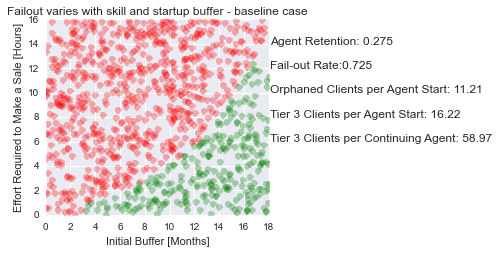

In [28]:
plotter(results0, 'Failout varies with skill and startup buffer - baseline case')

## Improving Productivity
When the productivity improves (ie, more time with client, overhead declines, etc) for a given skill, this is the same as scaling the phenomenon according to the effort required to make a sale, as they are multiplied by one another.

In [23]:
params={'startup_subsidy':0,'startup_subsidy_length':0, 
        'minimum_time_to_make_a_sale':1,
        'fraction_of_effort_for_sales':.5*1.25}

results1 = [runner(case, params) for case in cases[:]]

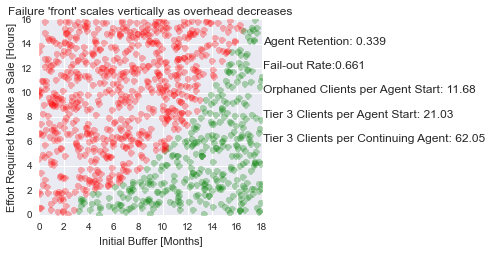

In [29]:
plotter(results1, "Failure 'front' scales vertically as overhead decreases")

## Startup Subsidy
If we implement a startup subsidy, we are essentially just increasing the startup buffer of all individuals uniformly, shifting the failure front to the left.

In [30]:
params={'startup_subsidy':.25,'startup_subsidy_length':6, 
        'minimum_time_to_make_a_sale':1,
        'fraction_of_effort_for_sales':.5}

results2 = [runner(case, params) for case in cases[:]]

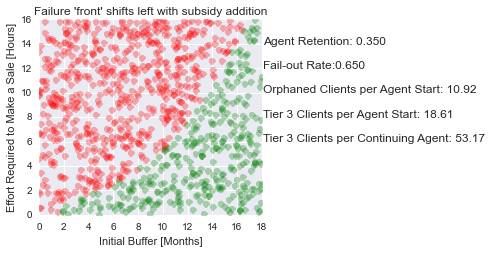

In [31]:
plotter(results2, "Failure 'front' shifts left with subsidy addition")

## Performance Monitoring

We could chose to fire individuals if they don't perform. What does that do to the result?

In [291]:
params={'startup_subsidy':.3,'startup_subsidy_length':6, 
        'minimum_time_to_make_a_sale':1,
        'fraction_of_effort_for_sales':.65}

results3 = [runner(case, params) for case in cases[:]]

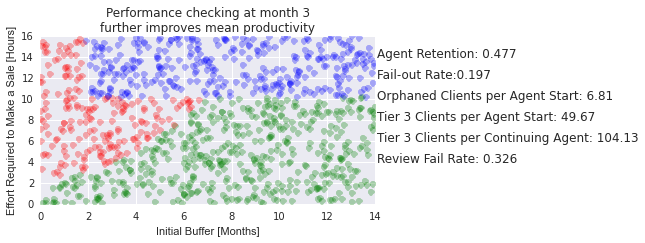

In [293]:
plotter(results3, "Performance checking at month 3\nfurther improves mean productivity", fire_level=4)